## Morphological reconstruction

In [1]:
import cv2
import numpy as np

img = cv2.imread('spine1.jpg',0) # get gray scale of the image

# Resize
# scale_percent = 20 # percent of original size
# width = int(img.shape[1] * scale_percent / 100)
# height = int(img.shape[0] * scale_percent / 100)
# dim = (width, height)
# resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
resized = img

kernel = np.ones((8,8),np.uint8)
erosion = cv2.erode(resized,kernel,iterations = 1)

 


# Debug
cv2.imshow("img_window",erosion)
cv2.waitKey()
cv2.destroyAllWindows()

# Filename
filename = 'spine_temp.jpg'
  
# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, erosion)


True

# l0 gradient minimization

In [2]:
import numpy as np
from scipy.fftpack import fft, ifft, fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt

import sys
import os
import argparse
from skimage import io
import skimage.data
import skimage.transform
import skimage.color

In [3]:

def get_configuration(add_arguments_func=None):
    lmd=0.02
    beta_max=1.0e5
    beta_rate=2.0
    resized=512

    img = io.imread(filename)

    # resize
    size = resized
    print(f"img.shape:{img.shape}")
    org_h, org_w = img.shape[:2]
    if org_h < org_w:
        w, h = (size, size*org_h/org_w)
    else:
        w, h = (size*org_w/org_h, size)
    print(f"{org_w}, {org_h}, {w}, {h}")
    print('{}: {}x{} -> {}x{}'.format(filename, org_w, org_h, w, h))
    img = skimage.transform.resize(img, (int(h), int(w)))

    # access to commonly used arguments
    return img, (lmd, beta_max, beta_rate)



In [4]:

img, (lmd, beta_max, beta_rate) = get_configuration()

img.shape:(4032, 3024)
3024, 4032, 384.0, 512
spine_temp.jpg: 3024x4032 -> 384.0x512


In [5]:

def clip_img(img):
    return np.clip(img, 0, 1)
def add_noise(img, sigma):
    return  clip_img(img + np.random.randn(*img.shape) * sigma)

In [6]:
from PIL import Image
import scipy.misc
import matplotlib

In [7]:

def l0_gradient_minimization_2d(I, lmd, beta_max, beta_rate=2.0, max_iter=30, return_history=False):
    u'''image I can be both 1ch (ndim=2) or D-ch (ndim=D)'''
    S = np.array(I)

    # prepare FFT
    F_I = fft2(S, axes=(0, 1))
    Ny, Nx = S.shape[:2]
    D = S.shape[2] if S.ndim == 3 else 1
    dx, dy = np.zeros((Ny, Nx)), np.zeros((Ny, Nx))
    print(f"{Ny/2}, {Nx/2-1},{Nx/2+1}")
    dx[int(Ny/2), int(Nx/2-1):int(Nx/2+1)] = [-1, 1]
    dy[int(Ny/2-1):int(Ny/2+1), int(Nx/2)] = [-1, 1]
    F_denom = np.abs(fft2(dx))**2.0 + np.abs(fft2(dy))**2.0
    if D > 1: F_denom = np.dstack([F_denom]*D)

    S_history = [S]
    beta = lmd * 2.0
    hp, vp = np.zeros_like(S), np.zeros_like(S)
    for i in range(max_iter):
        # with S, solve for hp and vp in Eq. (12)
        hp, vp = circulant2_dx(S, 1), circulant2_dy(S, 1)
        if D == 1:
            mask = hp**2.0 + vp**2.0 < lmd/beta
        else:
            mask = np.sum(hp**2.0 + vp**2.0, axis=2) < lmd/beta
        hp[mask] = 0.0
        vp[mask] = 0.0

        # with hp and vp, solve for S in Eq. (8)
        hv = circulant2_dx(hp, -1) + circulant2_dy(vp, -1)
        S = np.real(ifft2((F_I + (beta*fft2(hv, axes=(0, 1))))/(1.0 + beta*F_denom), axes=(0, 1)))

        # iteration step
        if return_history:
            S_history.append(np.array(S))
        beta *= beta_rate
        if beta > beta_max: break

    if return_history:
        return S_history

    return S

In [8]:

# 2D
def circulantshift2_x(xs, h):
    return np.hstack([xs[:, h:], xs[:, :h]] if h > 0 else [xs[:, h:], xs[:, :h]])

def circulantshift2_y(xs, h):
    return np.vstack([xs[h:, :], xs[:h, :]] if h > 0 else [xs[h:, :], xs[:h, :]])

def circulant2_dx(xs, h):
    return (circulantshift2_x(xs, h) - xs)

def circulant2_dy(xs, h):
    return (circulantshift2_y(xs, h) - xs)

ax:AxesSubplot(0.672059,0.536818;0.227941x0.343182),lmd:0.002
256.0, 191.0,193.0
ax:AxesSubplot(0.125,0.125;0.227941x0.343182),lmd:0.01
256.0, 191.0,193.0
ax:AxesSubplot(0.398529,0.125;0.227941x0.343182),lmd:0.03
256.0, 191.0,193.0
ax:AxesSubplot(0.672059,0.125;0.227941x0.343182),lmd:0.05
256.0, 191.0,193.0


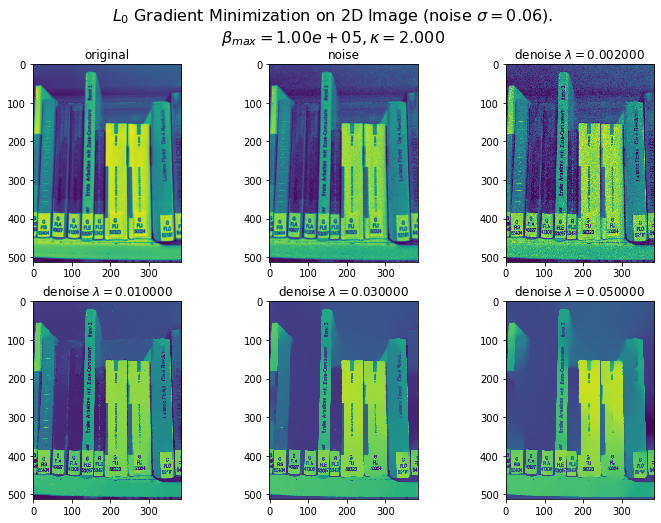

In [9]:
sigma = 0.06
img_noise = add_noise(img, sigma)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle((r'$L_0$ Gradient Minimization on 2D Image (noise $\sigma={:.3}$).' + '\n'
    + r'$\beta_{{max}}={:.2e}, \kappa={:.3f}$').format(sigma, beta_max, beta_rate),
    fontsize=16)
axs[0, 0].imshow(img)
axs[0, 0].set_title('original')
axs[0, 1].imshow(img_noise)
axs[0, 1].set_title('noise')

denoise_axs = [axs[0, 2], axs[1, 0], axs[1, 1], axs[1, 2]]
best_res = 0
for ax, lmd in zip(denoise_axs, [0.002, 0.01, 0.03, 0.05]):
    print(f"ax:{ax},lmd:{lmd}")
    res = l0_gradient_minimization_2d(img_noise, lmd, beta_max, beta_rate)
    if lmd==0.05:
        best_res = res
    ax.imshow(clip_img(res), interpolation='nearest')
    ax.set_title('denoise $\\lambda = %f$' % lmd)
matplotlib.image.imsave("l0_result.jpg",clip_img(best_res))


In [11]:
import cv2
import numpy as np

img = cv2.imread('l0_result.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)


lines = cv2.HoughLines(edges,1,np.pi/180,150)
print(len(lines[0]))
print(len(lines))

for index, line in enumerate(lines):
    if index==20:
        break
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

cv2.imshow("test", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1
5
